In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from datetime import datetime

# Load actors with score

In [4]:
actors = pd.read_csv('fomc_scorecard.csv', sep=";", index_col=3, header=0)
actors = actors[actors['Score'] != 0]

# Load articles

In [5]:
from pymongo import MongoClient

In [6]:
client = MongoClient('localhost', 27017)
fomc_collection = client.python_import.fomc_articles

In [7]:
fomc_articles = pd.DataFrame(list(fomc_collection.find()))
fomc_articles.set_index('_id', inplace=True)

# Merge articles and actors score

In [8]:
fomc_articles_scored = fomc_articles.merge(actors, left_on='ParticipantName', right_index=True)
fomc_articles_scored.head(2)

,ParticipantJobTitle,ParticipantLocation,ParticipantName,ParticipantTitleLastName,ParticipantUrl,RemarkDate,RemarkDescription,RemarkType,content,date,url,Name,Score,Shifted score
_id,,,,,,,,,,,,,,
58cab2973740f50f2c6fdccb,Pres.,Richmond,Jeffrey Lacker,Pres. Lacker,/fomcspeak/jeffrey-lacker,"Dec. 03, 2013",Lacker Testifies on Bankruptcy and Financial I...,Testimony,Good morning. I am honored to speak to the Sub...,2013-12-03 00:00:00,https://www.richmondfed.org/press_room/speeche...,Jeffrey M. Lacker,2,4
58cab29e3740f50f2c6fdcce,Pres.,Richmond,Jeffrey Lacker,Pres. Lacker,/fomcspeak/jeffrey-lacker,"Apr. 18, 2013 (8:06 AM ET)",Fed's Lacker Would End QE Now,Video Interview,Fed's Lacker Would End QE Now\n\t\t\t\t\n In a...,2013-04-18 08:06:00,http://video.cnbc.com/gallery/?video=3000162414,Jeffrey M. Lacker,2,4


# Number of articles in each score class

In [9]:
fomc_articles_scored.groupby('Score')['url'].count()

Score
-2    148
-1    168
 1    150
 2     72
Name: url, dtype: int64

# Create train data and test data

In [10]:
train_data = fomc_articles_scored[fomc_articles_scored['date'] < datetime(2016, 1, 1)]
test_data = fomc_articles_scored[fomc_articles_scored['date'] >= datetime(2016, 1, 1)]

In [11]:
X_train = train_data['content']
y_train = train_data['Score']
X_test = test_data['content']
y_test = test_data['Score']

# Tf-Idf and Multinomial Naive-Bayes model

In [26]:
pipeline = Pipeline([
    ('bow', CountVectorizer(ngram_range=(1,3), max_df=0.1, min_df=1, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('bayes_model', MultinomialNB())
])

In [27]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.1, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
        s...=False, use_idf=True)), ('bayes_model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [28]:
y_predicted = pipeline.predict(X_test)

#### Confusion matrix
By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
is equal to the number of observations known to be in group :math:`i` but
predicted to be in group :math:`j`.

In [29]:
cm = confusion_matrix(y_test, y_predicted)

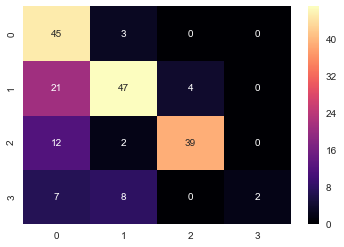

In [30]:
sns.heatmap(cm, cmap='magma', annot=True)

In [31]:
cr = classification_report(y_test, y_predicted)
print(cr)

             precision    recall  f1-score   support

         -2       0.53      0.94      0.68        48
         -1       0.78      0.65      0.71        72
          1       0.91      0.74      0.81        53
          2       1.00      0.12      0.21        17

avg / total       0.77      0.70      0.69       190



# Playground

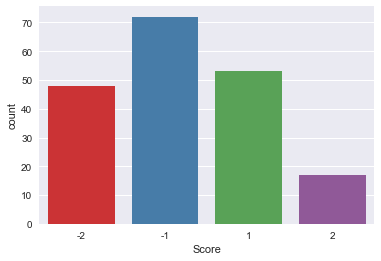

In [32]:
sns.countplot(y_test, palette="Set1")

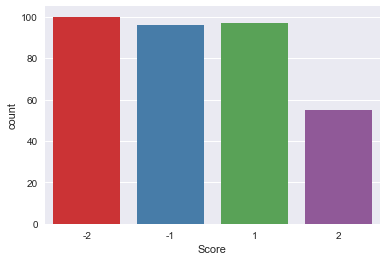

In [33]:
sns.countplot(y_train, palette="Set1")